In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# 1. Kernels
First we define functions that will be used to rerpersent the convolution kernel:

<ipython-input-215-db5b5e51911e>:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lags = np.array([Laguerre(i+1)(t+5) for i in range(20)])


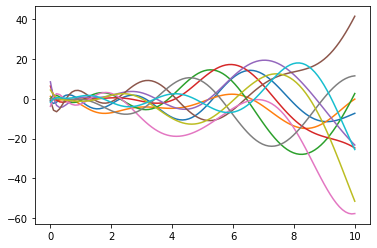

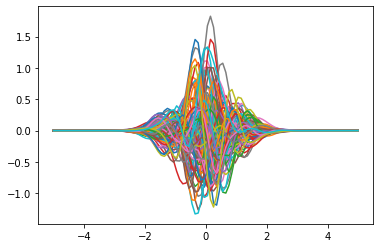

In [215]:
class Continuous():
    def __init__(self, ):
        pass
    
    def generator(self,):
        
        pass
    
    
class Laguerre(Continuous):
    def __init__(self, order):
        self.order = order
    
    def generator(self, t):
        return f_Laguerre(t, self.order) 
    
    def __call__(self, t):
        return self.generator(t)
    
class Gauss_Hermite(Continuous):
    def __init__(self, order, beta):
        self.order = order
        self.beta = beta
    
    def generator(self, t):
        return f_Gauss_Hermite(t, self.order, self.beta) 
    
    def __call__(self, t):
        return self.generator(t)
    
class GH_polynomial(Continuous):
    def __init__(self, weights, beta):
        self.weights = weights
        self.beta = beta
        self.order = len(weights)
    
    def generator(self, t):
        vectors = np.array([Gauss_Hermite(i+1, self.beta)(t) for i in range(self.order)])
        return np.dot(vectors.T, self.weights) 
    
    def __call__(self, t):
        return self.generator(t)
    
def f_Laguerre(t, order):
    """ Computes Laguerre polynomials at a given `order` at position `t`
    """
    if order == 1:
        return 1
    if order == 2:
        return -t+1
        
    Ln0 = 1
    Ln1 = -t+1
    n=2
    while n <= order:
        Ln = ((2*n+1-t)*Ln1-n*Ln0)/(n+1)
        Ln0=Ln1
        Ln1=Ln
        n+=1
    return Ln

def f_Gauss_Hermite(t, order, beta = 1):
    """ Computes Laguerre polynomials at a given `order` at position `t`
    """
    
    t = t/beta
    if order == 1:
        return np.ones(len(t))*np.exp(-t**2/2)/(beta*2**order*(2*np.pi*np.math.factorial(order))**0.5)
    if order == 2:
        return 2*t*np.exp(-t**2/2)/(beta*2**order*(2*np.pi*np.math.factorial(order))**0.5)
        
    
    Ln0 = np.ones(len(t))
    Ln1 = 2*t
    n=2
    while n <= order:
        Ln = 2*t*Ln1-2*n*Ln0
        Ln0=Ln1
        Ln1=Ln
        n+=1
    return Ln*np.exp(-t**2/2)/(beta*2**order*(2*np.pi*np.math.factorial(order))**0.5)

t = np.linspace(-5,5,100)
lags = np.array([Laguerre(i+1)(t+5) for i in range(20)])

hermits = np.array([Gauss_Hermite(i+1, beta=0.5)(t) for i in range(20)])

for j in range(10):
    weights = np.random.randn(20)
    plt.plot(t+5, np.dot(lags.T, weights))

plt.show()

for j in range(100):
    weights = np.random.randn(20)
    plt.plot(t, np.dot(hermits.T, weights))

plt.show()

# 2. Convolution operator
We need to define a convolution operation that takes an arbitrary number of unevenly spaced samples and outputs a vector of a specific length.

<ipython-input-214-464cd77298a6>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lags = np.array([Laguerre(i+1)(t/100.) for i in range(20)])


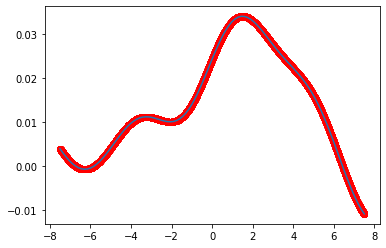

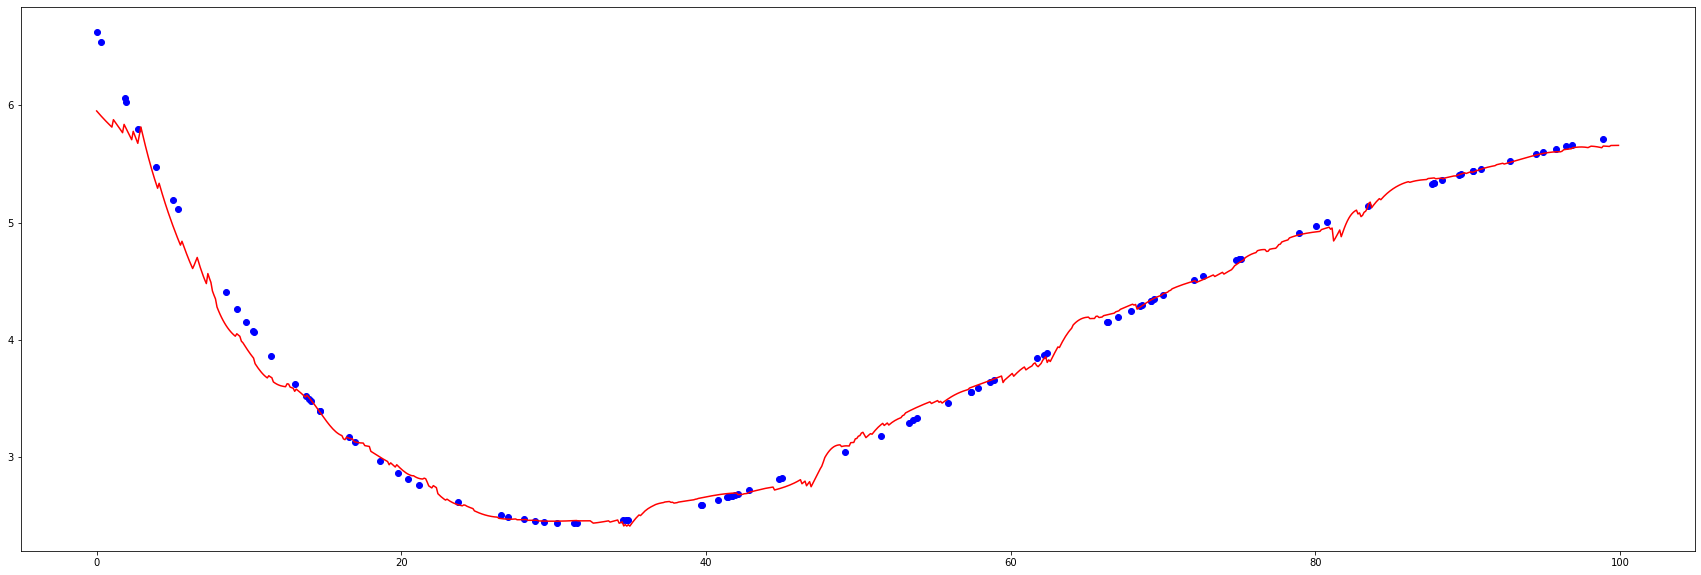

In [214]:
np.random.seed(1)
def continuous_conv(samples, times, kernel, kernel_length=None, length=None):
    """
    Parrameters
    -----------
    samples: numpy.ndarray
        A vector that contains the measured samples to convolve sorted by measured time
    times: numpy.ndarray
        The sorted times at which samples were recorded. Should be tthe same length as `samples`.
    kernel: Continuous
        A Continuous class instance
    length: `float`
        Length (in time units) of the convolution kernel.
    length: `int`
        Length of the output vector.
    Returns
    -------
    convolved: numpy.ndarray
        A vector that contains the result of the convolution.
    """
    assert len(samples) == len(times)
    if length is None:
        span = np.max(times) - np.min(times)
    t_start = np.min(times)#-kernel_length/2
    t_stop = np.max(times)#-kernel_length/2
    
    step_size = ((t_stop-t_start)/(length-1))
    norm = 1
    convolved = []
    for i in range(length):
        
        loc = np.where(np.abs(times-(t_start+i*step_size))<kernel_length/2.)
        t_compute = times[loc]
        s_compute = samples[loc]
        
        loc_kernel = kernel(t_compute-(t_start+i*step_size))/norm
        
        plt.plot(t_compute-(t_start+i*step_size), loc_kernel, 'or')
        
        convolved.append(np.sum(loc_kernel*s_compute)/(np.sum(loc_kernel)))
    plt.plot(np.linspace(-kernel_length/2, kernel_length/2, 100), 
                 kernel(np.linspace(-kernel_length/2, kernel_length/2, 100))/norm)
    plt.show()
    return np.array(convolved)
        

t = np.sort(np.random.rand(100)*100)
weights = np.random.randn(20)
lags = np.array([Laguerre(i+1)(t/100.) for i in range(20)])
s = np.dot(lags.T, weights)+5

beta = 3
kernel = GH_polynomial(np.random.randn(10), beta) 

length = 1000
conv = continuous_conv(s, t, kernel, kernel_length=beta*5, length=length)

plt.figure(figsize=(30,10))
plt.plot(t, s, 'ob')
plt.plot(np.arange(length)/length*100, conv, 'r')
plt.show()


In [177]:
class Linear(keras.layers.Layer):
    def __init__(self, order, length, functional = Laguerre(10),output_size=None, units=32):
        """ An attempt at building a continuous convolutional layer. 
        It uses Laguerre polynomials sampled at arbitrary locations to 
        generate discrete convolutional kernels that are drawn from the same continuous function.
        Parameters
        ----------
        order: `int`
            order of the Laguerre polynomials.
        length: `float`
            length (in physical units) of the convolution kernel. 
        span: `tuple`
            time span of the light curves.
        functional: `Continuous` object
            the function to use to generate convolution kernels.
        
        """
        super(Linear, self).__init__()
        self.units = units
        self.order = order
        self.span = span
        self.length = length
        self.functional = functional
        self.output_size = output_size
        self.limits = [-length/2., span[1]+length/2.]
        if output_size is None:
            # Default: output size means that the kernel is applied twice to each point on the curve
            self.output_size = 2*(span[1]-span[0] +length)/length
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(order, units), dtype="float32"),
            trainable=True,
        )
        b_init = tf.zeros_initializer()
        
    def convovle_op(self, inputs, times):
        assert inputs.shape == times.shape
        
        
        
        
    def call(self, inputs, times):
        
        return tf.matmul(inputs, self.w) + self.b


In [4]:
x = tf.ones((2, 2))
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(x)
print(y)
print(linear_layer.w)

TypeError: __init__() missing 1 required positional argument: 'span'